# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [1]:
# Standard libraries
import os
import inspect

# Data manipulation
import numpy as np
import pandas as pd

# Statistical functions
from scipy.stats import norm

# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss,
)

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


In [2]:
# SETRED
import sys
sys.path.append(os.path.abspath(".."))
from setred_package import setred_scratch, simulated_data,  setred_scratch_v2
from utils.adspy_shared_utilities import plot_class_regions_for_classifier

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

In [3]:
X = np.load("../data/X.npy")
y = np.load("../data/y.npy")
X_unlabel = np.load("../data/X_unlabel.npy")
y_unlabel = np.load("../data/y_unlabel.npy")
X_ori = np.load("../data/X_ori.npy")
y_ori = np.load("../data/y_ori.npy")
X_test = np.load("../data/X_test.npy")
y_test = np.load("../data/y_test.npy")

In [4]:
colors =    [ 
    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
    '#00FFFF',  # Cyan / Aqua
]

cmap_bold = ListedColormap(colors = colors)



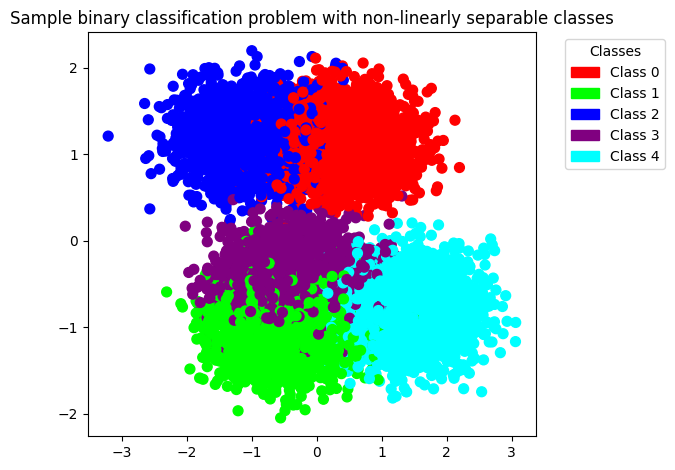

In [5]:

plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_ori[:,0], X_ori[:,1], c=y_ori,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_ori)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Generation of artificial semisupervised learning


In [6]:
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y: {pd.Series(y).value_counts(normalize=False).sort_index()}")


Shape of X: (9750, 5), y: (9750,), X_unlabel: (9653, 5), y_unlabel: (9653,)
Frequencies of classes in y: -1    9653
 0      13
 1      24
 2      15
 3      21
 4      24
Name: count, dtype: int64


In [7]:
# Filtering the labeled instances
X_val = X[y != -1]
y_val = y[y != -1]
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val: {pd.Series(y_val).value_counts(normalize=False).sort_index()}")
print(f"Frequencies of classes in y_test: {pd.Series(y_test).value_counts(normalize=False).sort_index()}")


Shape of X_val: (97, 5), y_val: (97,), X_test: (3250, 5), y_test: (3250,)
Frequencies of classes in y_val: 0    13
1    24
2    15
3    21
4    24
Name: count, dtype: int64
Frequencies of classes in y_test: 0    650
1    650
2    650
3    650
4    650
Name: count, dtype: int64


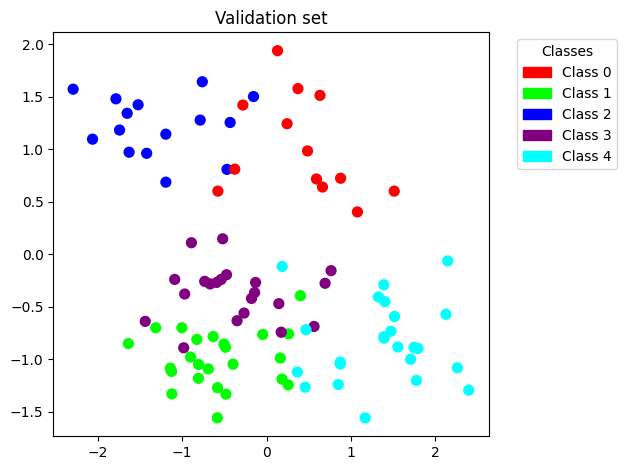

In [8]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_val)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

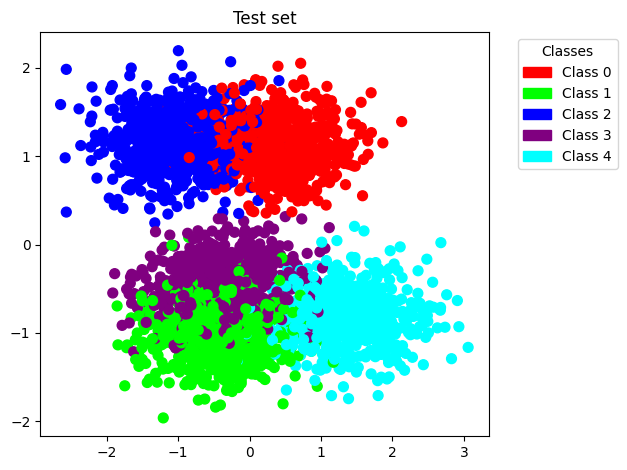

In [9]:
plt.figure()
plt.title('Test set')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,
           marker= 'o', s=50, cmap=cmap_bold)

unique_classes = np.unique(y_test)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Decision Tree

- Hyperparamter tunning with the validation data
- Check the performance of the classifier on the test data

In [13]:
# Fitting a decision tree with hyperparameters tunning using cross validation
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(dt, param_grid, cv=5)
print("The shape of X_val:", X_val.shape)
print("The shape of y_val:", y_val.shape)

grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_dt = DecisionTreeClassifier(**best_params, random_state=42)

The shape of X_val: (97, 5)
The shape of y_val: (97,)
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [14]:
# Fit the base estimator on the validation set
 dt_fitted = base_estimator_dt.fit(X_val, y_val)

In [15]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_dt.predict(X_val)
y_test_pred = base_estimator_dt.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 1.0
Accuracy of the base estimator on the test set: 0.9252307692307692
Classification report on validation set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        24

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Classification report on test set:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       650
           1       0.95      0.92      0.94       650
           2       0.94      0.93      0.94       650
           3       0.87      0.91      0.89       650
           4       0.94      0.92      

In [16]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_dt.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))


Accuracy of the base estimator on the unlabeled set: 0.9225111364342692
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1937
           1       0.95      0.93      0.94      1926
           2       0.93      0.93      0.93      1935
           3       0.87      0.90      0.89      1929
           4       0.94      0.91      0.93      1926

    accuracy                           0.92      9653
   macro avg       0.92      0.92      0.92      9653
weighted avg       0.92      0.92      0.92      9653



# SETRED CLASSIFIER

In [17]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Decision Tree

In [18]:
# Fitting the Setred classifier
ssl_clf_dt = setred_scratch.Setred_scratch(base_estimator=base_estimator_dt,
                        graph_neighbors=50,
                        max_iterations=40,                             
                        htunning=True,
                        param_grid={
                                'max_depth': [None, 5, 10, 15],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4, 5, 15]
                            },
                        X_test =X_test, # This is a matrix with the test instances to evaluate the model.
                        y_test=y_test,
                        y_real_label = y_unlabel,                            
                        view =10)
ssl_clf_dt.fit(X, y)


---------------------------------------------------------------
-------------------Iteration 10 Started ------------
---------------------------------------------------------------
Distribution of predicted classes in the unlabeled set:
0    23
1    18
2    28
3     3
4    25
Name: count, dtype: int64
Distribution of real classes in the unlabeled set:
0    24
1    18
2    27
4    28
Name: count, dtype: int64
--------------------------------------------------------------
----------------------Simulation------------------------------
--------------------------------------------------------------
Simulation verification of the real labels of the unlabeled dataset
Iteration 10 - Accuracy: 0.9570
Iteration 10: Report of the base estimator 
:               precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       1.00      1.00      1.00        18
           2       0.96      0.93      0.94        27
           3       0.00      0.00   

Setred_scratch(X_test=array([[-0.77386801,  0.91393718,  0.45838719, -2.06331441, -1.88502076],
       [ 1.22601857, -0.23235781, -2.15052087,  0.30945195,  0.17721097],
       [ 0.08511313, -1.46941818,  0.57309643,  0.56057669,  0.76332383],
       ...,
       [ 0.8723636 , -0.84462254, -1.56126331,  0.10212189, -0.30338588],
       [-0.34049474, -0.40304738, -0.50286151, -0.43231011, -0.65014946],
       [-0.87596852,  0.81471607,  1.05536645, -1.36583667,  0.08124485]]),
               base_estimator=DecisionTreeClassifier(random_state=42),
               graph_neighbors=50, htunning=True,
               param_grid={'max_depth': [None, 5, 10, 15],
                           'min_samples_leaf': [1, 2, 4, 5, 15],
                           'min_samples_split': [2, 5, 10]},
               view=10, y_real_label=array([4, 1, 4, ..., 2, 2, 2]),
               y_test=array([2, 4, 1, ..., 4, 3, 2]))

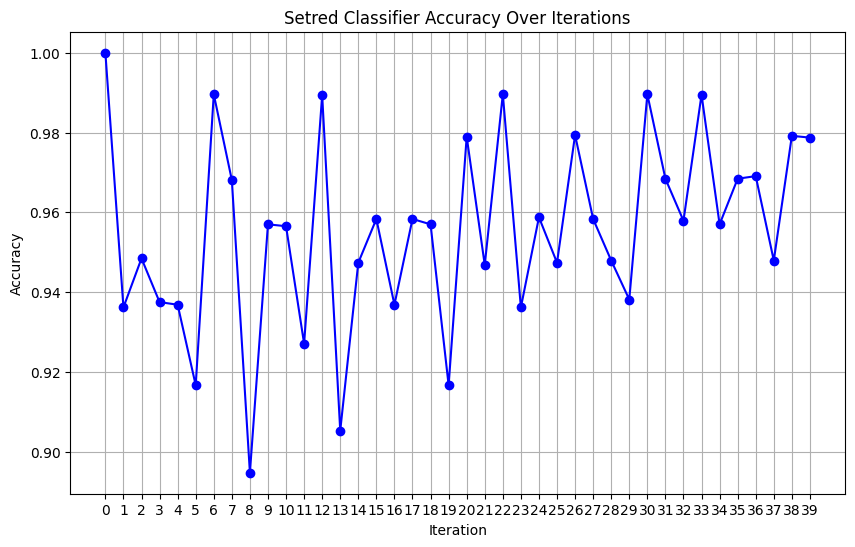

In [20]:
# Plot the accuracy of the Setred classifier
plt.figure(figsize=(10, 6))
plt.plot(ssl_clf_dt.accuracy_, marker='o', linestyle='-', color='b')
plt.title('Setred Classifier Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(len(ssl_clf_dt.accuracy_)))
plt.grid()



# Simulation score

In [38]:
# Simulation of the accuracy score
score = []
for i in range(100):
    # Fitting the Setred classifier
    ssl_clf_dt = setred_scratch.Setred_scratch(base_estimator=base_estimator_dt,
                                graph_neighbors=50,
                                max_iterations=40,                             
                                htunning=True,
                                param_grid={
                                        'max_depth': [None, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10],
                                        'min_samples_leaf': [1, 2, 4, 5, 15]
                                    },
                                X_test =X_test, # This is a matrix with the test instances to evaluate the model.
                                y_test=y_test,
                                y_real_label = y_unlabel,   
                                messages=False,                         
                                view =10)
    ssl_clf_dt.fit(X, y)
    # Score
    score.append(ssl_clf_dt.score(X_test, y_test))
    

Accuracy score: 0.9255323076923075


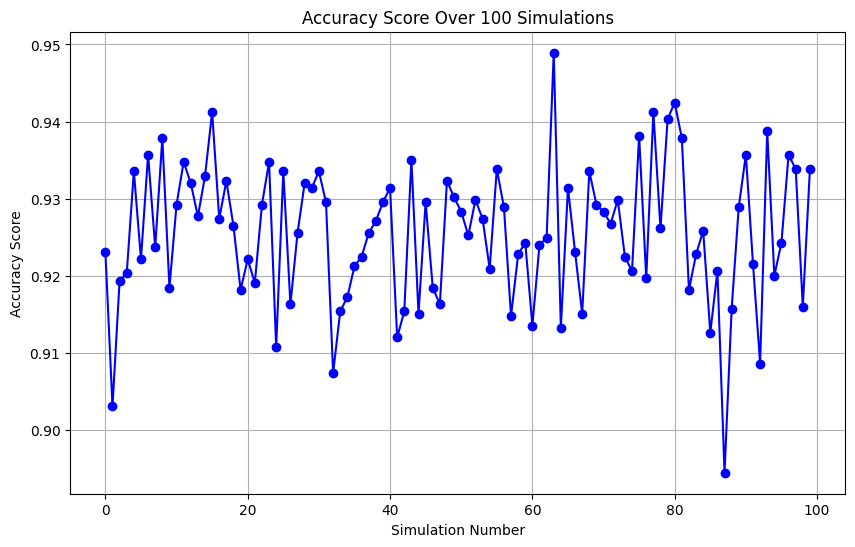

In [39]:
# Display the accuracy score
print(f"Accuracy score: {np.mean(score)}")
# Line plot 
plt.figure(figsize=(10, 6))
plt.plot(score, marker='o', linestyle='-', color='b')
plt.title('Accuracy Score Over 100 Simulations')
plt.xlabel('Simulation Number')
plt.ylabel('Accuracy Score')
plt.grid()
plt.show()

# Evaluation Metric

In [50]:
# Accuracy score
## Base setimiator
y_pred = base_estimator_dt.predict(X_test)
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_pred)}")
accuracy_score_dt = ssl_clf_dt.score(X_test, y_test)
print(f"Accuracy of the Setred classifier on the test set: {accuracy_score_dt}")
# The difference between the base estimator and the Setred classifier
print(f"Difference between the base estimator and the Setred classifier: {accuracy_score_dt - accuracy_score(y_test, y_pred)}")
# The percentage of improvement
improvement = (accuracy_score_dt - accuracy_score(y_test, y_pred)) / accuracy_score(y_test, y_pred) * 100
print(f"Percentage of improvement: {improvement:.2f}%")


Accuracy of the base estimator on the test set: 0.9252307692307692
Accuracy of the Setred classifier on the test set: 0.9338461538461539
Difference between the base estimator and the Setred classifier: 0.008615384615384691
Percentage of improvement: 0.93%


In [51]:
# Accuracy score
## Base setimiator
y_pred = base_estimator_dt.predict(X_unlabel)
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_unlabel, y_pred)}")
accuracy_score_dt = ssl_clf_dt.score(X_unlabel, y_unlabel)
print(f"Accuracy of the Setred classifier on the test set: {accuracy_score_dt}")
# The difference between the base estimator and the Setred classifier
print(f"Difference between the base estimator and the Setred classifier: {accuracy_score_dt - accuracy_score(y_unlabel, y_pred)}")
# The percentage of improvement
improvement = (accuracy_score_dt - accuracy_score(y_unlabel, y_pred)) / accuracy_score(y_unlabel, y_pred) * 100
print(f"Percentage of improvement: {improvement:.2f}%")

Accuracy of the base estimator on the test set: 0.9225111364342692
Accuracy of the Setred classifier on the test set: 0.9321454470112919
Difference between the base estimator and the Setred classifier: 0.009634310577022687
Percentage of improvement: 1.04%


In [53]:
# Generate predictions on the test set
y_pred = ssl_clf_dt.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       650
           1       0.96      0.94      0.95       650
           2       0.92      0.95      0.94       650
           3       0.93      0.90      0.92       650
           4       0.90      0.96      0.93       650

    accuracy                           0.93      3250
   macro avg       0.93      0.93      0.93      3250
weighted avg       0.93      0.93      0.93      3250



In [54]:
# Generate predictions on the test set
y_pred = ssl_clf_dt.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       650
           1       0.96      0.94      0.95       650
           2       0.92      0.95      0.94       650
           3       0.93      0.90      0.92       650
           4       0.90      0.96      0.93       650

    accuracy                           0.93      3250
   macro avg       0.93      0.93      0.93      3250
weighted avg       0.93      0.93      0.93      3250



# Comparison between the trees

In [46]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [47]:
names = [ "f" + str(i) for i in range(X.shape[1]) ]
names

['f0', 'f1', 'f2', 'f3', 'f4']

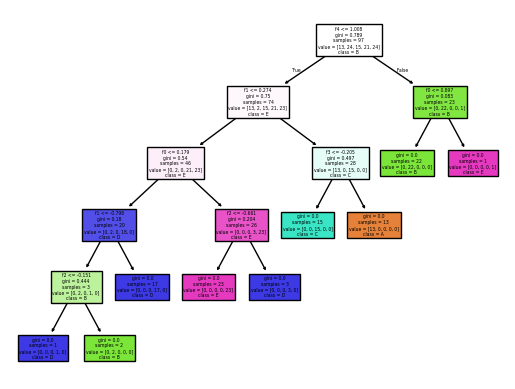

In [48]:
plot_tree(base_estimator_dt, feature_names=names, class_names=["A", "B","C","D","E"], filled=True)
plt.show()

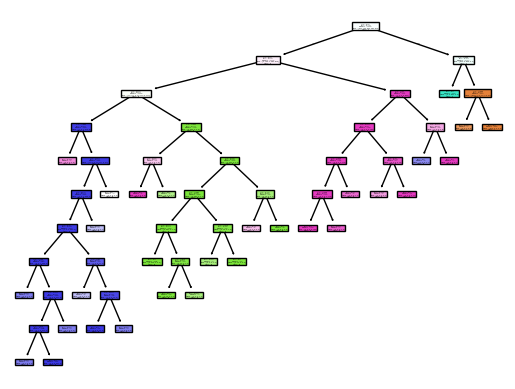

In [49]:
plot_tree(ssl_clf_dt._base_estimator, feature_names=names, class_names=["A", "B","C","D","E"], filled=True)
plt.show()